# Oceanographic satellite data from ESA CCI

In this notebook SST and Chl-a data from the ESA CCI project are analysed.

In [17]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
import glob

In [18]:
# SST satellite observation:
#     1. L4 (daily) https://catalogue.ceda.ac.uk/uuid/62c0f97b1eac4e0197a674870afe1ee6 
#     2. climatology (daily) https://catalogue.ceda.ac.uk/uuid/83e51cf29821434ea14db56c564946d5

# Download them locally with. e.g.
# wget -r -nH --cut-dirs 8 -e robots=off --reject 'index*' https://dap.ceda.ac.uk/neodc/esacci/sst/data/CDR_v2/Climatology/L4/v2.1/

path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/'

In [48]:
area_str = 'med'; area_name = 'Mediterranean Sea'
minlon = -5.6; maxlon = 43.4; minlat = 30; maxlat = 47.5;
area_str = 'pelagos'; area_name = 'Pelagos sanctuary'
minlon = 4.5; maxlon = 12; minlat = 39.5; maxlat = 45;

extent_param = [minlon, maxlon, minlat, maxlat]
crs = ccrs.PlateCarree()

def plot_background(ax):
    ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

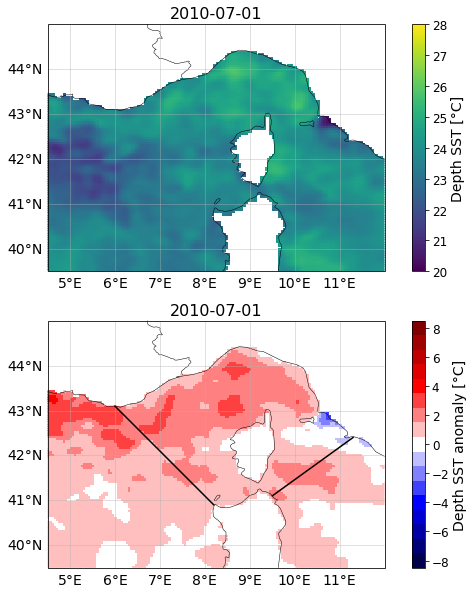

In [50]:
# Print a map of the SST for a given day and its anomaly with respect to the climatology.

str_doi = '2010-07-01' # string of the day of interest 'YYYY-MM-DD'

instant = np.datetime64(str_doi)
pd_instant = pd.to_datetime(instant)
year_oi = str(pd_instant.year).zfill(4)
month_oi = str(pd_instant.month).zfill(2)
day_oi = str(pd_instant.day).zfill(2)
doy = dt.datetime(int(year_oi), int(month_oi), int(day_oi)).timetuple().tm_yday
doy_str = str(doy).zfill(3) # 3 digits string with the day of the year.

# Set the path to the SST data. For a given day, read the L4 daily map over the area of interest.
path_sst_oi = path2sst + '/Analysis/L4/v2.1/' +  year_oi + '/' + month_oi + '/' + day_oi + '/'
filename_sst = sorted(glob.glob(path_sst_oi + '*2.1-v*')) # this removes the file with the 'anomaly' in their name.
ds_sst = xr.open_dataset(filename_sst[0])
lon_sst = ds_sst.lon.sel(lon=slice(extent_param[0],extent_param[1])).values
lat_sst = ds_sst.lat.sel(lat=slice(extent_param[2],extent_param[3])).values
l4_sst = ds_sst.analysed_sst[0].sel(lon=slice(extent_param[0],extent_param[1])).sel(lat=slice(extent_param[2],extent_param[3])).values
llon, llat = np.meshgrid(lon_sst,lat_sst)
# Read the anomaly.
filename_sst_an = sorted(glob.glob(path_sst_oi + '*anomaly*')) # this selects the file with the anomaly.
ds_sst_an = xr.open_dataset(filename_sst_an[0])
l4_sst_an = ds_sst_an.analysed_sst_anomaly[0].sel(lon=slice(extent_param[0],extent_param[1])).sel(lat=slice(extent_param[2],extent_param[3])).values

# Plot the two maps.
from matplotlib import cm
seismic17 = cm.get_cmap('seismic', 17)

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2, 1, 1, projection=crs)
plot_background(ax1)
pc1 = ax1.pcolor(lon_sst,lat_sst,l4_sst-273.15,shading='nearest',transform=ccrs.PlateCarree(),vmin=20,vmax=28)
cbar1 = plt.colorbar(pc1)
cbar1.ax.tick_params(labelsize=12) 
cbar1.set_label('Depth SST [°C]',size=14)
ax1.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)

ax2 = fig.add_subplot(2, 1, 2, projection=crs)
plot_background(ax2)
pc2 = ax2.pcolor(lon_sst,lat_sst,l4_sst_an,shading='nearest',transform=ccrs.PlateCarree(),cmap=seismic17,
                 vmin=-8.5,vmax=8.5)
cbar2 = plt.colorbar(pc2)
cbar2.ax.tick_params(labelsize=12) 
cbar2.set_label('Depth SST anomaly [°C]',size=14)
ax2.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)


figure_name = area_str + '_l4_sst_map_' + year_oi + '-' + month_oi + '-' + day_oi + '.png'
#plt.savefig('./figures/'+figure_name,bbox_inches='tight')

lonA = 6.0
latA = 43.1
lonB = 8.2
latB = 40.9
lonC = 9.5
latC = 41.1
lonD = 11.3
latD = 42.4
ax2.plot([lonA,lonB],[latA,latB],'k-')
ax2.plot([lonC,lonD],[latC,latD],'k-')

In [39]:
# We can plot a map of the monthly mean SST and SST anomaly...

Text(0.5, 1.0, '2010-07-01')

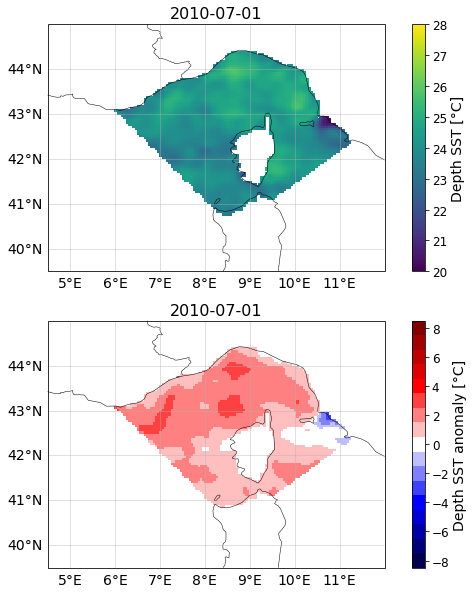

In [79]:
# Extract a time series of the SST over the Pelagos area.

# Define the mask over the Pelagos Sanctuary.
m1 = (latB-latA)/(lonB-lonA)
q1 = latA-m1*lonA
m2 = (latD-latC)/(lonD-lonC)
q2 = latC-m2*lonC
idpelagos = np.double((llat>m1*llon+q1)&(llat>m2*llon+q2))
idpelagos[idpelagos==0]=np.nan

# Check the mask with a map.
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2, 1, 1, projection=crs)
plot_background(ax1)
pc1 = ax1.pcolor(lon_sst,lat_sst,(l4_sst-273.15)*idpelagos,shading='nearest',transform=ccrs.PlateCarree(),vmin=20,vmax=28)
cbar1 = plt.colorbar(pc1)
cbar1.ax.tick_params(labelsize=12) 
cbar1.set_label('Depth SST [°C]',size=14)
ax1.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)

ax2 = fig.add_subplot(2, 1, 2, projection=crs)
plot_background(ax2)
pc2 = ax2.pcolor(lon_sst,lat_sst,l4_sst_an*idpelagos,shading='nearest',transform=ccrs.PlateCarree(),cmap=seismic17,
                 vmin=-8.5,vmax=8.5)
cbar2 = plt.colorbar(pc2)
cbar2.ax.tick_params(labelsize=12) 
cbar2.set_label('Depth SST anomaly [°C]',size=14)
ax2.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)

In [85]:
# Define the time window of interest.
str_start = '2010-01-01'
str_end = '2010-12-31'

mean_sst = [] # Spatial mean of the SST.
std_sst = [] # Spatial standard deviation of the SST.
mean_sst_an = [] # Spatial mean of the SST climatological anomaly.
time = []

# Loop on time.
instant_start = np.datetime64(str_start)
instant = instant_start
instant_end = np.datetime64(str_end)
count = 0

while instant<=instant_end:
    pd_instant = pd.to_datetime(instant)
    year_oi = str(pd_instant.year).zfill(4)
    month_oi = str(pd_instant.month).zfill(2)
    day_oi = str(pd_instant.day).zfill(2)
    doy = dt.datetime(int(year_oi), int(month_oi), int(day_oi)).timetuple().tm_yday
    doy_str = str(doy).zfill(3) # 3 digits string with the day of the year.

    # Set the path to the SST data. For a given day, read the L4 daily map over the area of interest.
    path_sst_oi = path2sst + '/Analysis/L4/v2.1/' +  year_oi + '/' + month_oi + '/' + day_oi + '/'
    filename_sst = sorted(glob.glob(path_sst_oi + '*2.1-v*')) # this removes the file with the 'anomaly' in their name.
    ds_sst = xr.open_dataset(filename_sst[0])
    if count==0:
        lon_sst = ds_sst.lon.sel(lon=slice(extent_param[0],extent_param[1])).values
        lat_sst = ds_sst.lat.sel(lat=slice(extent_param[2],extent_param[3])).values
        llon, llat = np.meshgrid(lon_sst,lat_sst)

    l4_sst = ds_sst.analysed_sst[0].sel(lon=slice(extent_param[0],extent_param[1])).sel(lat=slice(extent_param[2],extent_param[3])).values
    # Read the anomaly.
    filename_sst_an = sorted(glob.glob(path_sst_oi + '*anomaly*')) # this selects the file with the anomaly.
    ds_sst_an = xr.open_dataset(filename_sst_an[0])
    l4_sst_an = ds_sst_an.analysed_sst_anomaly[0].sel(lon=slice(extent_param[0],extent_param[1])).sel(lat=slice(extent_param[2],extent_param[3])).values

    mean_oi = np.nanmean((l4_sst-273.15)*idpelagos) # Compute the spatial mean of the SST over the Pelagos area only.
    std_oi = np.nanstd((l4_sst-273.15)*idpelagos)
    mean_oi_an = np.nanmean(l4_sst_an*idpelagos) # Compute the spatial mean of the SST anomaly over the Pelagos area only.
    
    mean_sst.extend([mean_oi])
    std_sst.extend([std_oi])
    mean_sst_an.extend([mean_oi_an])
    time.extend([instant])
    
    print(instant)
    instant += np.timedelta64(1,'D')
    count += 1

2010-01-01
2010-01-02
2010-01-03
2010-01-04
2010-01-05
2010-01-06
2010-01-07
2010-01-08
2010-01-09
2010-01-10
2010-01-11
2010-01-12
2010-01-13
2010-01-14
2010-01-15
2010-01-16
2010-01-17
2010-01-18
2010-01-19
2010-01-20
2010-01-21
2010-01-22
2010-01-23
2010-01-24
2010-01-25
2010-01-26
2010-01-27
2010-01-28
2010-01-29
2010-01-30
2010-01-31
2010-02-01
2010-02-02
2010-02-03
2010-02-04
2010-02-05
2010-02-06
2010-02-07
2010-02-08
2010-02-09
2010-02-10
2010-02-11
2010-02-12
2010-02-13
2010-02-14
2010-02-15
2010-02-16
2010-02-17
2010-02-18
2010-02-19
2010-02-20
2010-02-21
2010-02-22
2010-02-23
2010-02-24
2010-02-25
2010-02-26
2010-02-27
2010-02-28
2010-03-01
2010-03-02
2010-03-03
2010-03-04
2010-03-05
2010-03-06
2010-03-07
2010-03-08
2010-03-09
2010-03-10
2010-03-11
2010-03-12
2010-03-13
2010-03-14
2010-03-15
2010-03-16
2010-03-17
2010-03-18
2010-03-19
2010-03-20
2010-03-21
2010-03-22
2010-03-23
2010-03-24
2010-03-25
2010-03-26
2010-03-27
2010-03-28
2010-03-29
2010-03-30
2010-03-31
2010-04-01

Text(0.5, 0, 'Time')

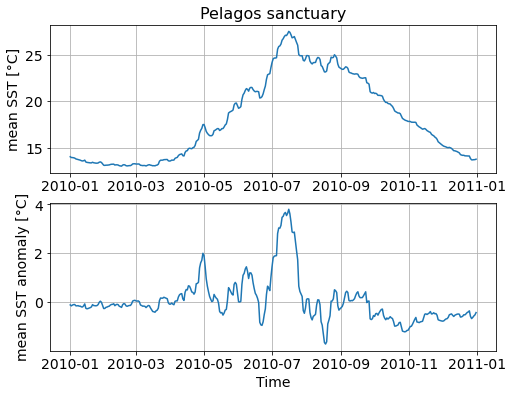

In [91]:
mean_sst = np.array(mean_sst)    
std_sst = np.array(std_sst)    
mean_sst_an = np.array(mean_sst_an)    

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(time,mean_sst)
ax1.grid()
ax1.tick_params(axis='both',labelsize=14)
ax1.set_ylabel('mean SST [°C]',fontsize=14)
ax1.set_title(area_name, fontsize=16)

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(time,mean_sst_an)
ax2.grid()
ax2.tick_params(axis='both',labelsize=14)
ax2.set_ylabel('mean SST anomaly [°C]',fontsize=14)
ax2.set_xlabel('Time',fontsize=14)
